<a href="https://colab.research.google.com/github/RayKoltner/datascience/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%9A%D1%83%D0%B2%D1%88%D0%B8%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Описание проекта

Вам предоставлена выгрузка заказов из CRM компании, занимающейся В2В-продажами.  На основе
этих данных вам нужно подготовить дашборд для директора компании, который даст общее
понимание ситуации с продажами, наглядно покажет ответы на вопросы:

1. Как менеджеры выполняют план продаж?
2. Какова помесячная динамика выполнения плана, есть ли сезонные «просадки»?
3. Какова география продаж, какие регионы самые доходные?
4. Как влияет канал продаж на выполнение плана, конверсию, длительность сделки?
5. Какие товарные категории пользуются спросом (по числу клиентов) и по продажам?

Дашборд должен дать информацию для принятия решений:
Профилировать ли менеджеров по товарным категориям или каналам продаж (где они лучше закрывают сделки, выполняют план)
Расширять самые доходные каналы продаж, регионы, где есть высокий спрос


Задание

Откройте файл с данными и изучите общую информацию
Подготовьте данные
Проведите исследовательский анализ данных
Составьте портрет менеджера каждого региона
Проведите исследование статистических показателей
Проверьте гипотезы
Напишите общий вывод


# Загрузка данных, изучение общей информации

In [94]:
#Youre code is here
import pandas as pd
data = pd.read_excel("https://github.com/RayKoltner/datascience/raw/refs/heads/main/xls_datasets/data.xlsx")
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Номер заказа                  116 non-null    int64         
 1   Канал продаж                  116 non-null    object        
 2   Продуктовый сегмент           116 non-null    object        
 3   Менеджер                      116 non-null    object        
 4   Название заказа               116 non-null    object        
 5   Продавец                      116 non-null    object        
 6   Город                         116 non-null    object        
 7   Продажи факт, тыс.руб         116 non-null    int64         
 8   Продажи план, тыс.руб         116 non-null    int64         
 9   Дата сделки                   116 non-null    datetime64[ns]
 10  Дата оплаты                   93 non-null     datetime64[ns]
 11  Дней между сделкой и оплатой  11

# Подготовка данных

Замените названия столбцов при необходимости (приведите к нижнему регистру); Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему; Обработайте пропуски при необходимости: Объясните, почему заполнили пропуски определённым образом или почему не стали это делать; Опишите причины, которые могли привести к пропускам; Посчитайте суммарные фактические продажи по всем городам и запишите их в отдельный столбец.

In [95]:
#Youre code is here
print(data.columns)

Index(['Номер заказа', 'Канал продаж', 'Продуктовый сегмент', 'Менеджер',
       'Название заказа', 'Продавец', 'Город', 'Продажи факт, тыс.руб',
       'Продажи план, тыс.руб', 'Дата сделки', 'Дата оплаты',
       'Дней между сделкой и оплатой', 'Статус'],
      dtype='object')


In [96]:
data = data.set_axis(labels = ["id",
                               "channel",
                               "category",
                               "manager",
                               "order_name",
                               "merchant",
                               "city",
                               "real_amount",
                               "planned_amount",
                               "deal_date",
                               "payment_date",
                               "days_between",
                               "status"], axis = 'columns')

In [97]:
print(data['status'].unique())

['Закрыто' 'В процессе' 'Потерянно']


Для удобства переведем статус в числовой формат.

In [98]:
def status_to_number(status):
  match status:
    case "Закрыто":
      return 2
    case "Потерянно":
      return 0
    case "В процессе":
      return 1

data['status'] = data['status'].map(lambda x: status_to_number(x))
print(data['status'].unique())

data["status"].astype((int))
print(data.groupby('status')['status'].count()) # Большинство сделок завершилось

[2 1 0]
status
0     9
1    14
2    93
Name: status, dtype: int64


In [99]:
print(data.isna().sum())

id                 0
channel            0
category           0
manager            0
order_name         0
merchant           0
city               0
real_amount        0
planned_amount     0
deal_date          0
payment_date      23
days_between       0
status             0
dtype: int64


Все имеющиеся пропуски находятся в стобце даты оплаты. Скорее всего это связано с тем, что некоторые сделки не были завершены на момент сбора данных или были отменены. Проверим это:

In [100]:
print(data[data["payment_date"].isna()]["status"].unique()) # Проверка значений статуса у строк с пустой датой оплаты

[1 0]


Как и ожидалось, строки с пустующей датой оплаты содержат информацию о незавершённых\отменённых сделках. Заполнять такие строки нет смысла, поскольку сама по себе дата оплаты ничего не сообщает кроме того, что сделка не была завершена. Для это же цели можно использовать столбец статуса.

In [101]:
data['days_between'].astype((int))

ValueError: invalid literal for int() with base 10: ' '

Как оказалось, поле количества прошедших дней между сделкой и оплатой также содержит пустые значения, хоть по общей статистике пропусков этого не видно. Исправим это и переведем столбец в целочисленный формат.

In [102]:
data['days_between'] = data['days_between'].replace(" ", "0")
data['days_between'].astype((int))

,days_between
0,52
1,15
2,0
3,1
4,87
...,...
111,0
112,13
113,9
114,5


Посчитаем продажи по городам, учитавая только завершенные сделки:

In [103]:
complete_deals = data[data["status"] == 2]
sells_by_cities = data.groupby("city")
print(sells_by_cities['status'].count().sort_values(ascending=False))

city
Магнитогорск       17
Москва             15
Сочи               11
Новосибирск        10
Самара             10
Оренбург            8
Казань              7
Челябинск           6
Санкт-Петербург     6
Волгоград           4
Уфа                 3
Нижний Новгород     3
Тула                3
Улан-Удэ            2
Пермь               2
Омск                2
Севастополь         1
Саратов             1
Стоврополь          1
Липецк              1
Курск               1
Кемерово            1
Ярославль           1
Name: status, dtype: int64


Продажи распределены по городам неравномерно. Неожиданным является то, что Москва или Санкт-Петербург не являются лидерами по количеству покупок. Самымы доходными регионами являются Магнитогорск, Москва, Сочи, Новосибирск и Самара. Около половины регионов приносят минимальный доход.

# Исследовательский анализ данных

Проведите исследовательский анализ данных

Посмотрите, как менеджеры выполняют план продаж.  Какова помесячная динамика выполнения плана, есть ли сезонные «просадки»? Важны ли данные за все периоды? Посмотрите, как менялись продажи по продуктовым сегментам. Выберите сегменты с наибольшими суммарными продажами и постройте распределение по месяцам. Есть ли популярные в прошлом сегменты, у которых сейчас продажи на нуле.

Какова география продаж, какие регионы самые доходные?

Как влияет канал продаж на выполнение плана, конверсию, длительность сделки?

Какие товарные категории пользуются спросом (по числу клиентов) и по продажам?

In [104]:
# Начнем с анализа эффективности менеджеров
# Введём столбец выполненности плана
data["completed_plan"] = data['real_amount'] >= data['planned_amount']
complete_deals = data[data["status"] == 2] # Обновим таблицу для завершенных сделок
print(data["completed_plan"].sum() / data["completed_plan"].count() * 100) # Сколько процентов от продаж
print(complete_deals["completed_plan"].sum() / complete_deals["completed_plan"].count() * 100) # Для завершенных продаж

29.310344827586203
36.55913978494624


Статистика печальная - только 29% продаж были равны плану или превосходили его. Если считать только по завершенным продажам, то получается около 36.6%. Это говорит о том, что незавершенные продажи не сильно портят статистику выполнения плана.

In [105]:
# Посмотрим, как конкретные менеджеры выполняют план

manager_efficiency = pd.pivot_table(complete_deals, index="manager", values="completed_plan")
print(manager_efficiency)

           completed_plan
manager                  
А. Перри         0.000000
А. Фостер        0.727273
М. Баили         0.416667
Р. Хайерс        0.333333
С. Милер         0.142857
Т. Ли            0.000000


Статистика показывает, что половина менеджеров никогда или почти никогда не выполняет план.

Перейдем к распределению продаж по времени

<Axes: xlabel='month'>

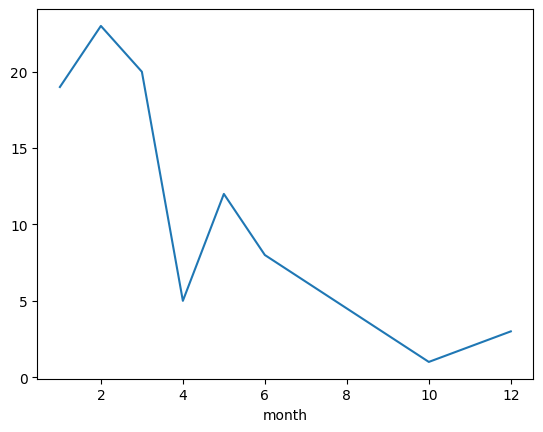

In [106]:
# Посмотрим на распределение продаж по времени
data['month'] = data["deal_date"].dt.month
complete_deals = data[data["status"] == 2] # Обновим таблицу для завершенных сделок
complete_deals.groupby('month')['status'].count().plot()

График показывает, что большинство сделок было заключено в первый кввартал года.

<Axes: xlabel='month'>

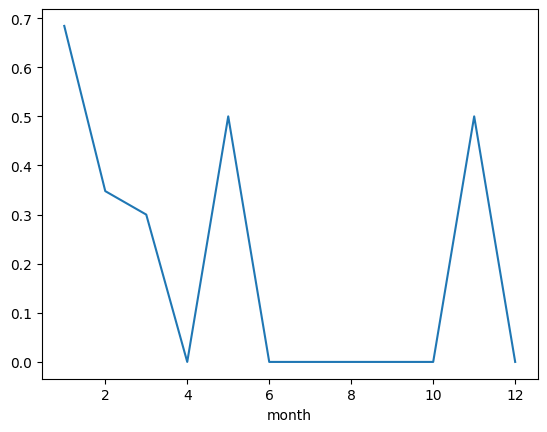

In [107]:
complete_deals.groupby('month')['completed_plan'].mean().plot()

График выполнения плана показывает, что все лето и большую часть осени идёт простой, план не выполняется совсем. Общее количество сделок в этот период также значительно снижается. Вывод: количество сделок подвержено сезонным перепадам

Перейдем к сегментам продаж

In [108]:
print(data.groupby('category')["status"].count().sort_values(ascending=False))

category
Оборудование              46
Ткань и аксессуары        21
Свет                      12
Другое                    10
Электронные устройства     7
Одежда                     6
Упаковка                   3
Игрушки                    2
Спорт товары               2
Сувениры                   2
Автозапчасти               1
Бассейн                    1
Косметика                  1
Медецина                   1
Охота и рыбалка            1
Name: status, dtype: int64


Больше всего закупают оборудования, также продаж в сегиенте ткани и аксессуаров достаточно много. Однако половина сегментов приносит меньше продаж в сумме, чем третье место в списке. Рассмотрим динамику продаж топ-3 категорий по времени.

<Axes: xlabel='month'>

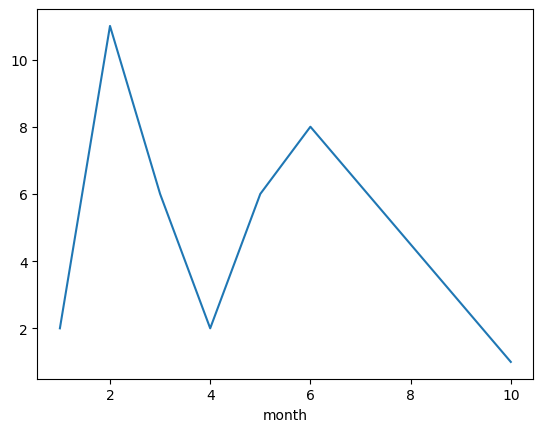

In [111]:
complete_deals[complete_deals['category'] == "Оборудование"].groupby('month')['status'].count().plot()

<Axes: xlabel='month'>

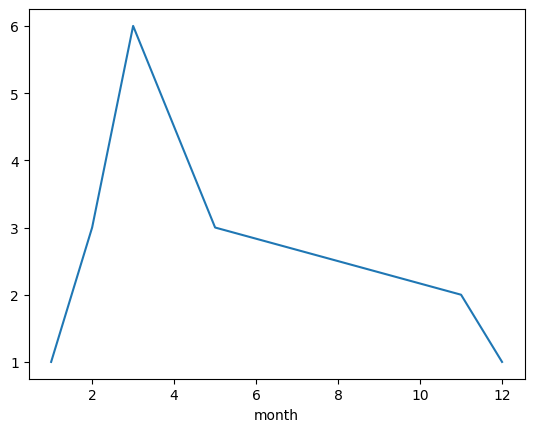

In [110]:
complete_deals[complete_deals['category'] == "Ткань и аксессуары"].groupby('month')['status'].count().plot()

<Axes: xlabel='month'>

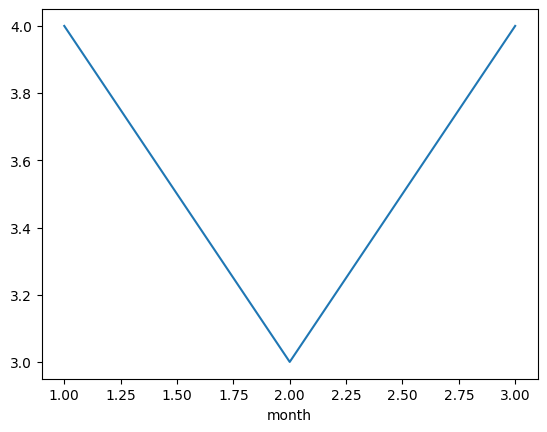

In [109]:
complete_deals[complete_deals['category'] == "Свет"].groupby('month')['status'].count().plot()

Картина продаж оборудования или ткани и аксессуаров примерно соответствует общей. Со светом же ситуация интересней: товары этого сегмента хорошо продавались в первый квартал года, а дальше продажи упали до 0

In [112]:
# Теперь посмотрим распределение по количеству клиентов
print(data.groupby('category')["merchant"].nunique().sort_values(ascending=False))

category
Оборудование              7
Ткань и аксессуары        6
Другое                    4
Одежда                    4
Электронные устройства    4
Свет                      2
Автозапчасти              1
Бассейн                   1
Игрушки                   1
Косметика                 1
Медецина                  1
Охота и рыбалка           1
Спорт товары              1
Сувениры                  1
Упаковка                  1
Name: merchant, dtype: int64


По количеству клиентов распределение примерно такое же, только сегмент "Свет" утратил своё третье место.

Вывод: большая часть категорий приносит минимум продаж. Есть смысл сфокусироваться на 5-10 сегментов с лучшими показателями

Перейдем к каналам продаж

In [120]:
# Создадим копию датасета, где статус будет бинарным
binary_status = data.copy()
binary_status['days_between'] = binary_status['days_between'].astype((int))
binary_status["status"] = binary_status["status"].map(lambda x: x > 1)
print(pd.pivot_table(binary_status, index="channel", values=['completed_plan', "status", "days_between"]))

                     completed_plan  days_between    status
channel                                                    
Вебсайт                    0.000000     13.333333  0.666667
Выставка                   0.277778      7.166667  0.777778
Контекстная реклама        0.000000     18.625000  0.625000
Почта                      0.250000     42.750000  0.750000
Рекомендация               0.343750     20.656250  0.781250
Холодный звонок            0.363636     40.030303  0.909091


Как и ожидалось, разные каналы дают разные результаты. Лучше всего работает холодный звонок, но в таком случае сделки долго длятся. Быстрее всего сделки происходят через канал выставок. Процент выполнения плана в целом ожидаемый, за исключением ссайта и рекламы - в случае этих каналов план не выполнялся никогда.

In [121]:
print(pd.pivot_table(binary_status, index="channel", values=["status"], aggfunc="count"))

                     status
channel                    
Вебсайт                   3
Выставка                 36
Контекстная реклама       8
Почта                     4
Рекомендация             32
Холодный звонок          33


# Общий вывод
На основании исследовательского анализа сделайте вывод относительно того, что стоит ли
 - Профилировать ли менеджеров по товарным категориям или каналам продаж (где они лучше закрывают сделки, выполняют план)
 - Расширять самые доходные каналы продаж, регионы, где есть высокий спрос

In [126]:
# Посмотрим на эффективность менеджеров в зависимости от канала
print(pd.pivot_table(binary_status, index="manager", columns="channel", values=["status"], fill_value="Не использует"))

                  status                                                    \
channel          Вебсайт       Выставка Контекстная реклама          Почта   
manager                                                                      
А. Перри   Не использует  Не использует       Не использует  Не использует   
А. Фостер  Не использует  Не использует       Не использует  Не использует   
М. Баили             0.5            1.0            0.666667           0.75   
Р. Хайерс            1.0       0.771429       Не использует  Не использует   
С. Милер   Не использует  Не использует       Не использует  Не использует   
Т. Ли      Не использует  Не использует                 0.6  Не использует   

                                          
channel     Рекомендация Холодный звонок  
manager                                   
А. Перри             1.0   Не использует  
А. Фостер  Не использует        0.916667  
М. Баили           0.875        0.882353  
Р. Хайерс  Не использует             1.

In [127]:
print(pd.pivot_table(binary_status, index="manager", columns="channel", values=["completed_plan"], fill_value="Не использует"))

          completed_plan                                                    \
channel          Вебсайт       Выставка Контекстная реклама          Почта   
manager                                                                      
А. Перри   Не использует  Не использует       Не использует  Не использует   
А. Фостер  Не использует  Не использует       Не использует  Не использует   
М. Баили             0.0            0.0                 0.0           0.25   
Р. Хайерс            0.0       0.285714       Не использует  Не использует   
С. Милер   Не использует  Не использует       Не использует  Не использует   
Т. Ли      Не использует  Не использует                 0.0  Не использует   

                                          
channel     Рекомендация Холодный звонок  
manager                                   
А. Перри             0.0   Не использует  
А. Фостер  Не использует        0.666667  
М. Баили           0.625        0.235294  
Р. Хайерс  Не использует             0.

**Вывод: Менеджеры явно лучше работают с определённым каналом связи. Профилирование менеджеров имеет смысл.**

**Вывод 2: есть смысл сфокусироваться только на опредеденных, самых выгодных, категориях (например, оборудование) и регионах (например, магнитогорск)**